In [1]:
import os
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xarray as xr
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Just start from cell that loads pickled data

# run_paths = ['csv/' + run for run in os.listdir('csv')]
# run = pd.read_csv(run_paths[0])

In [ ]:
print(run['./PPO_1/global_step'][488] / 2)
print(run['./PPO_1/global_step'][243])
print(run['./PPO_1/global_step'][244])

In [ ]:
len(run_paths)

In [ ]:
run.columns

In [ ]:
run[['./PPO_1/RewardPredictor+ICM/reward_extrinsic', './PPO_1/icm/reward_intrinsic']]

## Create multidimensional array (length x masscart x seed x metric x step)

In [5]:
# convert parameters into array indices
seed_indices = {i: i-1 for i in range(1,4)}

length_indices = {}
masscart_indices = {}
for i in range(13):
    length_val = round(0.5 + 0.1*i, 1)
    length_indices[length_val] = i
for i in range(13):
    masscart_val = round(1.0 + 0.2*i, 1)
    masscart_indices[masscart_val] = i
    
metric_indices = {
    "global_step": 0,
    "train/clip_fraction": 1,
    "RewardPredictor+ICM/reward_rp+icm+env": 2,
    "RewardPredictor+ICM/reward_extrinsic": 3,
    "RewardPredictor/loss": 4,
    "RewardPredictor/prediction_reward_intrinsic": 5,
    "RewardPredictor/prediction_reward_combined": 6,
    "RewardPredictor/predicted_reward": 7,
    "icm/policy_loss": 8,
    "icm/reward_combined": 9,
    "icm/reward_intrinsic": 10
}

In [ ]:
a = np.full([len(length_indices.keys()), len(masscart_indices.keys()), len(seed_indices), 
             len(metric_indices.keys()), 489], np.nan)

In [ ]:
da = xr.DataArray(a, dims=["length", "masscart", "seed", "metric", "step"], 
                  attrs={"len_dict": length_indices, "mc_dict": masscart_indices, 
                         "seed_dict": seed_indices, "metric_dict": metric_indices})

for rp in run_paths:
    run = pd.read_csv(rp)
    _, length, _, masscart, _, seed = rp[:-4].split('_')
    l_idx = length_indices[float(length)]
    mc_idx = masscart_indices[float(masscart)]
    s_idx = seed_indices[int(seed)]
    
    # rename columns to get rid of "./PPO_.../"
    col_rename = {col: col[8:] if col[0] == '.' else col for col in run.columns}
    run = run.rename(columns=col_rename)
    
    # drop redundant global step column
    run = run.loc[:,~run.columns.duplicated()]
    
    for metric in metric_indices.keys():
        m_idx = metric_indices[metric]
        da[l_idx, mc_idx, s_idx, m_idx,] = run[metric]
    

In [ ]:
# pickle this large xarray
# with open('data.pkl', 'wb') as file:
#     pickle.dump(da, file)

## Analysis of results

In [2]:
## Load xarray back in for analysis
with open('data.pkl', 'rb') as file:
    da = pickle.load(file)

### Functions

In [3]:
mid_time_step = int(489/2)

def sum_experiment_metric(arr, l_idx, mc_idx, seed_idx, metric_idx):
    return float(arr[l_idx, mc_idx, seed_idx, metric_idx, mid_time_step:].sum())


def cumsum_experiment_metric(arr, l_idx, mc_idx, seed_idx, metric_idx):
    return arr[l_idx, mc_idx, seed_idx, metric_idx, mid_time_step:].cumsum()


def average_experiment_metric_across_seeds(arr, l_idx, mc_idx, metric_idx):
    return np.nanmean([arr[l_idx, mc_idx, 0, metric_idx, mid_time_step:],
                       arr[l_idx, mc_idx, 1, metric_idx, mid_time_step:],
                       arr[l_idx, mc_idx, 2, metric_idx, mid_time_step:]])

def average_max_value_experiment_metric(arr, l_idx, mc_idx, metric_idx):
    return np.nanmean([np.nanmax(arr[l_idx, mc_idx, 0, metric_idx, mid_time_step:]),
                       np.nanmax(arr[l_idx, mc_idx, 1, metric_idx, mid_time_step:]),
                       np.nanmax(arr[l_idx, mc_idx, 2, metric_idx, mid_time_step:])])

In [6]:
intrinsic_rewards = np.full([len(length_indices.keys()), len(masscart_indices.keys())], np.nan)
for l, l_idx in length_indices.items():
    for mc, mc_idx in masscart_indices.items():
        intrinsic_rewards[l_idx, mc_idx] = average_experiment_metric_across_seeds(da, l_idx, 
                                                mc_idx, metric_indices["icm/reward_intrinsic"])

In [7]:
reward_losses = np.full([len(length_indices.keys()), len(masscart_indices.keys())], np.nan)
for l, l_idx in length_indices.items():
    for mc, mc_idx in masscart_indices.items():
        reward_losses[l_idx, mc_idx] = average_experiment_metric_across_seeds(da, l_idx, 
                                                mc_idx, metric_indices["RewardPredictor/loss"])

extrinsic_rewards = np.full([len(length_indices.keys()), len(masscart_indices.keys())], np.nan)
for l, l_idx in length_indices.items():
    for mc, mc_idx in masscart_indices.items():
        extrinsic_rewards[l_idx, mc_idx] = average_experiment_metric_across_seeds(da, l_idx, 
                                                mc_idx, metric_indices["RewardPredictor+ICM/reward_extrinsic"])

max_reward_loss = np.full([len(length_indices.keys()), len(masscart_indices.keys())], np.nan)
for l, l_idx in length_indices.items():
    for mc, mc_idx in masscart_indices.items():
        max_reward_loss[l_idx, mc_idx] = average_max_value_experiment_metric(da, l_idx, 
                                                mc_idx, metric_indices["RewardPredictor/loss"])

max_intrinsic_reward = np.full([len(length_indices.keys()), len(masscart_indices.keys())], np.nan)
for l, l_idx in length_indices.items():
    for mc, mc_idx in masscart_indices.items():
        max_intrinsic_reward[l_idx, mc_idx] = average_max_value_experiment_metric(da, l_idx, 
                                                mc_idx, metric_indices["icm/reward_intrinsic"])

## Surfaces

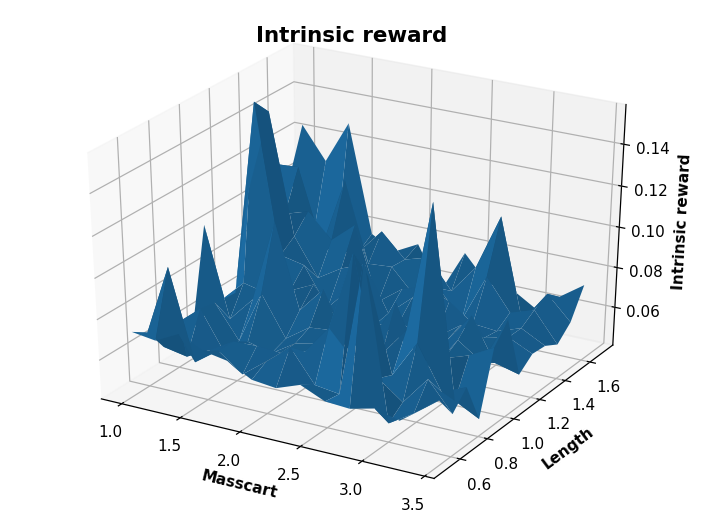

In [8]:
# Set up grid and test data
# y = range(len(length_indices.keys()))
# x = range(len(masscart_indices.keys()))
y = list(length_indices.keys())
x = list(masscart_indices.keys())

hf = plt.figure(figsize=(8,6), dpi=110)
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, intrinsic_rewards)

ha.set_xlabel("Masscart", weight="bold")
ha.set_ylabel("Length", weight="bold")
ha.set_zlabel("Intrinsic reward", weight="bold")
ha.set_title("Intrinsic reward", weight="bold", size=14)

# plt.savefig("intrinsic_reward_surface_plot.png")
plt.show()

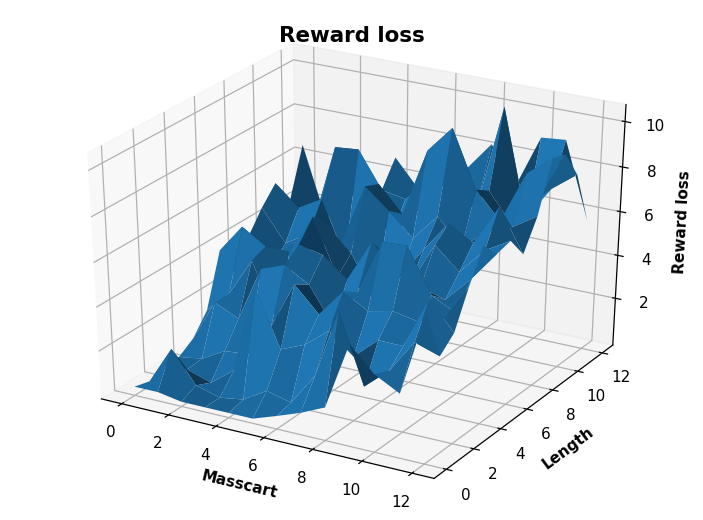

In [9]:
# Set up grid and test data
y = range(len(length_indices.keys()))
x = range(len(masscart_indices.keys()))

hf = plt.figure(figsize=(8,6), dpi=110)
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, reward_losses)

ha.set_xlabel("Masscart", weight="bold")
ha.set_ylabel("Length", weight="bold")
ha.set_zlabel("Reward loss", weight="bold")
ha.set_title("Reward loss", weight="bold", size=14)

# plt.savefig("reward_loss_surface_plot.png")
plt.show()

## Heatmaps

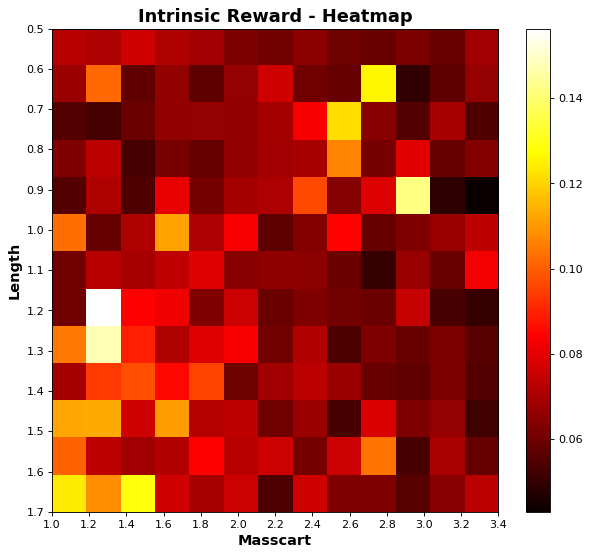

In [10]:
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)

ax.set_title("Intrinsic Reward - Heatmap", weight="bold", size=16)
ax.set_ylabel("Length", weight="bold", size=13)
ax.set_xlabel("Masscart", weight="bold", size=13)

ax.set(xticks=list(masscart_indices.keys()), xticklabels=list(masscart_indices.keys()),
       yticks=list(length_indices.keys())[::-1], yticklabels=list(length_indices.keys())[::-1])
pos = ax.imshow(intrinsic_rewards, cmap="hot", interpolation=None, extent=[1.0, 3.4, 1.7, 0.5],
         aspect="auto")
plt.colorbar(pos, cmap="Reds")
plt.show()
# plt.savefig("intrinsic_reward_heatmap.png")

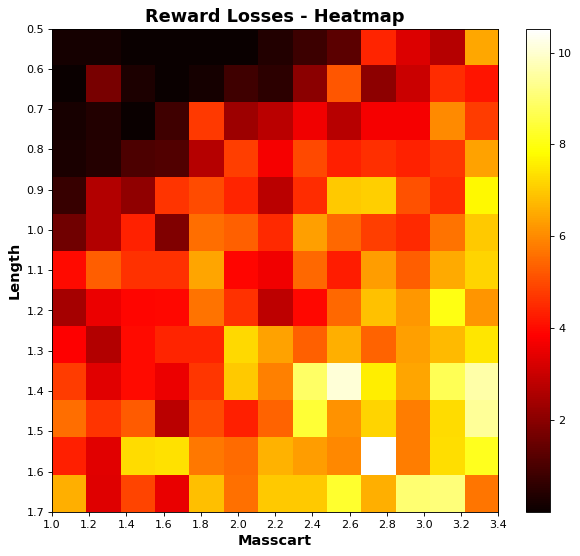

In [11]:
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)

ax.set_title("Reward Losses - Heatmap", weight="bold", size=16)
ax.set_ylabel("Length", weight="bold", size=13)
ax.set_xlabel("Masscart", weight="bold", size=13)

ax.set(xticks=list(masscart_indices.keys()), xticklabels=list(masscart_indices.keys()),
       yticks=list(length_indices.keys())[::-1], yticklabels=list(length_indices.keys())[::-1])
pos = ax.imshow(reward_losses, cmap="hot", interpolation=None, extent=[1.0, 3.4, 1.7, 0.5],
         aspect="auto")

plt.colorbar(pos, cmap="hot")
plt.show()
# plt.savefig("reward_losses_heatmap.png")

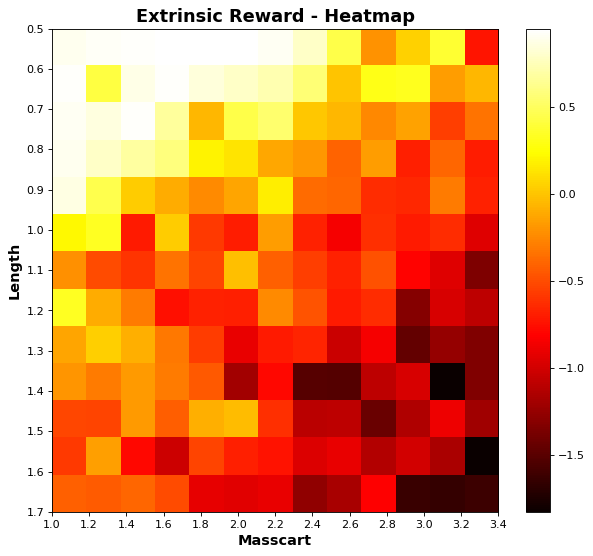

In [12]:
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)

ax.set_title("Extrinsic Reward - Heatmap", fontweight="bold", size=16)
ax.set_ylabel("Length", fontweight="bold", size=13)
ax.set_xlabel("Masscart", fontweight="bold", size=13)

ax.set(xticks=list(masscart_indices.keys()), xticklabels=list(masscart_indices.keys()),
       yticks=list(length_indices.keys())[::-1], yticklabels=list(length_indices.keys())[::-1])
pos = ax.imshow(extrinsic_rewards, cmap="hot", interpolation=None, extent=[1.0, 3.4, 1.7, 0.5],
         aspect="auto")

plt.colorbar(pos, cmap="hot")
plt.show()
# plt.savefig("extrinsic_reward_heatmap.png")

## Line plot - Masscart effect not very large

## Policy failure map


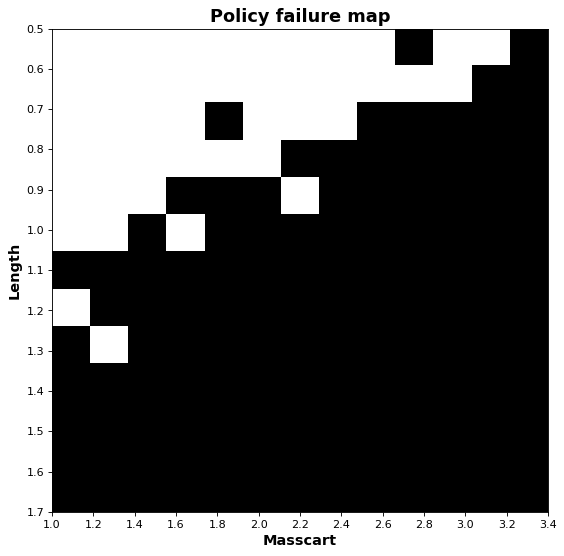

In [13]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.set(xticks=list(masscart_indices.keys()), xticklabels=list(masscart_indices.keys()),
       yticks=list(length_indices.keys())[::-1], yticklabels=list(length_indices.keys())[::-1])
ax.imshow(extrinsic_rewards > 0, cmap="gray", interpolation=None, extent=[1.0, 3.4, 1.7, 0.5],
         aspect="auto")

ax.set_xlabel("Masscart", fontweight="bold", size=13)
ax.set_ylabel("Length", fontweight="bold", size=13)
ax.set_title("Policy failure map", fontweight="bold", size=16)

plt.show()
# plt.savefig("policy_failure_map.png")

## Magnitude of changepoint spikes

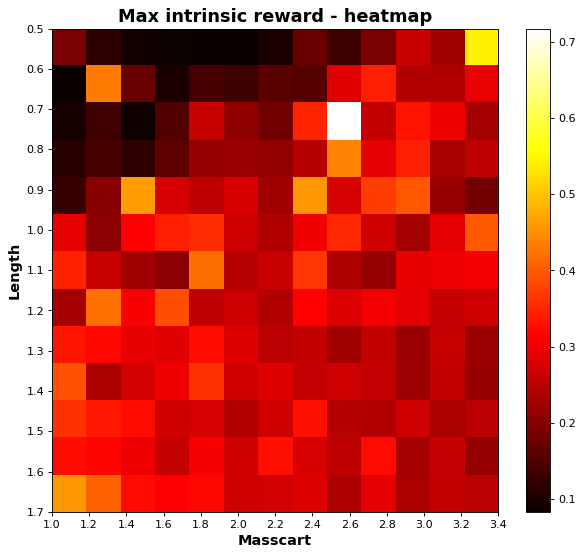

In [14]:
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)

ax.set_title("Max intrinsic reward - heatmap", fontweight="bold", size=16)
ax.set_ylabel("Length", fontweight="bold", size=13)
ax.set_xlabel("Masscart", fontweight="bold", size=13)

ax.set(xticks=list(masscart_indices.keys()), xticklabels=list(masscart_indices.keys()),
       yticks=list(length_indices.keys())[::-1], yticklabels=list(length_indices.keys())[::-1])
pos = ax.imshow(max_intrinsic_reward, cmap="hot", interpolation=None, extent=[1.0, 3.4, 1.7, 0.5],
         aspect="auto")

plt.colorbar(pos, cmap="hot")
# plt.show()
# plt.savefig("max_intrinsic_reward_heatmap.png")

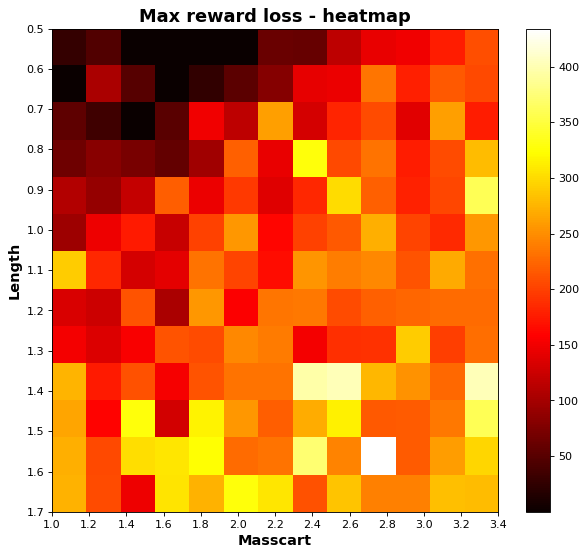

In [15]:
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)

ax.set_title("Max reward loss - heatmap", fontweight="bold", size=16)
ax.set_ylabel("Length", fontweight="bold", size=13)
ax.set_xlabel("Masscart", fontweight="bold", size=13)

ax.set(xticks=list(masscart_indices.keys()), xticklabels=list(masscart_indices.keys()),
       yticks=list(length_indices.keys())[::-1], yticklabels=list(length_indices.keys())[::-1])
pos = ax.imshow(max_reward_loss, cmap="hot", interpolation=None, extent=[1.0, 3.4, 1.7, 0.5],
         aspect="auto")

plt.colorbar(pos, cmap="hot")
plt.show()
# plt.savefig("max_reward_loss_heatmap.png")

## Scatterplot - Max Reward Loss vs Degree Policy Failure

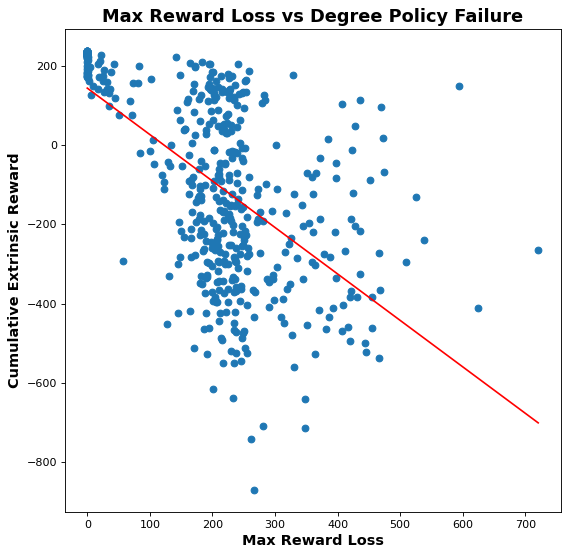

In [140]:
degree_failure = np.nansum(da[:,:,:,metric_indices["RewardPredictor+ICM/reward_extrinsic"],mid_time_step:], axis=3)
max_reward_loss = np.nanmax(da[:,:,:,metric_indices["RewardPredictor/loss"],mid_time_step:], axis=3)

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.scatter(max_reward_loss.flatten(), degree_failure.flatten())
ax.set_xlabel("Max Reward Loss", fontweight="bold", size=13)
ax.set_ylabel("Cumulative Extrinsic Reward", fontweight="bold", size=13)
ax.set_title("Max Reward Loss vs Degree Policy Failure", fontweight="bold", size=16)

ax.plot(np.unique(max_reward_loss.flatten()), np.poly1d(
            np.polyfit(max_reward_loss.flatten(), 
            degree_failure.flatten(), 1))(np.unique(max_reward_loss.flatten())),
        color="red")

plt.show()
# plt.savefig('max_reward_loss_scatterplot.png')

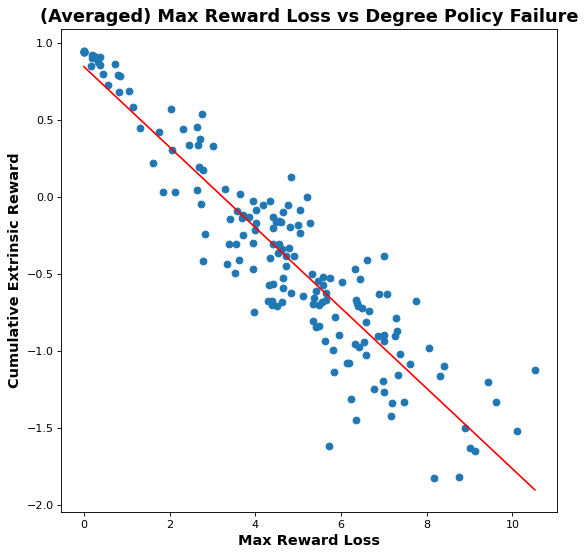

In [17]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.scatter(reward_losses.flatten(), extrinsic_rewards.flatten())
ax.set_xlabel("Max Reward Loss", fontweight="bold", size=13)
ax.set_ylabel("Cumulative Extrinsic Reward", fontweight="bold", size=13)
ax.set_title("(Averaged) Max Reward Loss vs Degree Policy Failure", fontweight="bold", size=16)

ax.plot(np.unique(reward_losses.flatten()), np.poly1d(
            np.polyfit(reward_losses.flatten(), 
            extrinsic_rewards.flatten(), 1))(np.unique(reward_losses.flatten())),
        color="red")
        
plt.show()
# plt.savefig('averaged_max_reward_loss_scatterplot.png')

## Scatterplot - Initial Reward Loss vs Degree Policy Failure

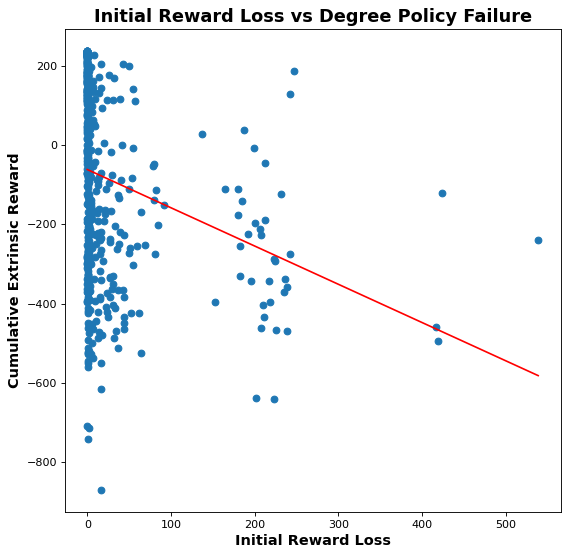

In [18]:
initial_reward_loss = np.array(da[:,:,:,metric_indices["RewardPredictor/loss"],mid_time_step+1])

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.scatter(initial_reward_loss.flatten(), degree_failure.flatten())
ax.set_xlabel("Initial Reward Loss", fontweight="bold", size=13)
ax.set_ylabel("Cumulative Extrinsic Reward", fontweight="bold", size=13)
ax.set_title("Initial Reward Loss vs Degree Policy Failure", fontweight="bold", size=16)

ax.plot(np.unique(initial_reward_loss.flatten()), np.poly1d(
            np.polyfit(initial_reward_loss.flatten(), 
            degree_failure.flatten(), 1))(np.unique(initial_reward_loss.flatten())),
        color="red")
              
plt.show()
# plt.savefig('initial_reward_loss_scatterplot.png')

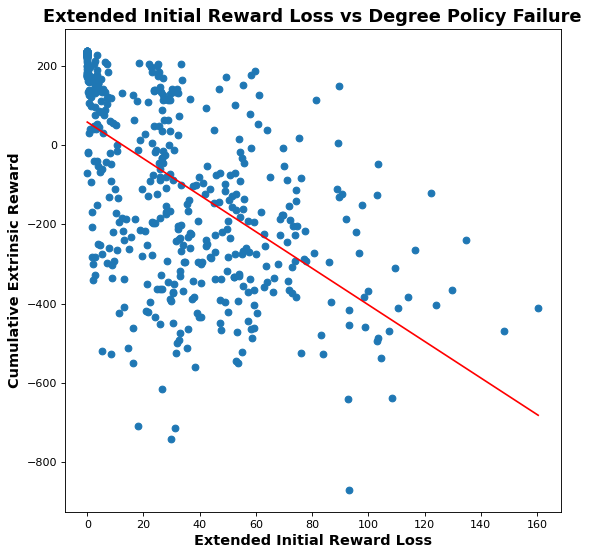

In [19]:
extended_initial_reward_loss = np.nanmean(da[:,:,:,metric_indices["RewardPredictor/loss"],mid_time_step+1:mid_time_step+10], axis=3)

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.scatter(extended_initial_reward_loss.flatten(), degree_failure.flatten())
ax.set_xlabel("Extended Initial Reward Loss", fontweight="bold", size=13)
ax.set_ylabel("Cumulative Extrinsic Reward", fontweight="bold", size=13)
ax.set_title("Extended Initial Reward Loss vs Degree Policy Failure", fontweight="bold", size=16)

ax.plot(np.unique(extended_initial_reward_loss.flatten()), np.poly1d(
            np.polyfit(extended_initial_reward_loss.flatten(), 
            degree_failure.flatten(), 1))(np.unique(extended_initial_reward_loss.flatten())),
        color="red")

plt.show()
# plt.savefig('extended_initial_reward_loss_scatterplot.png')

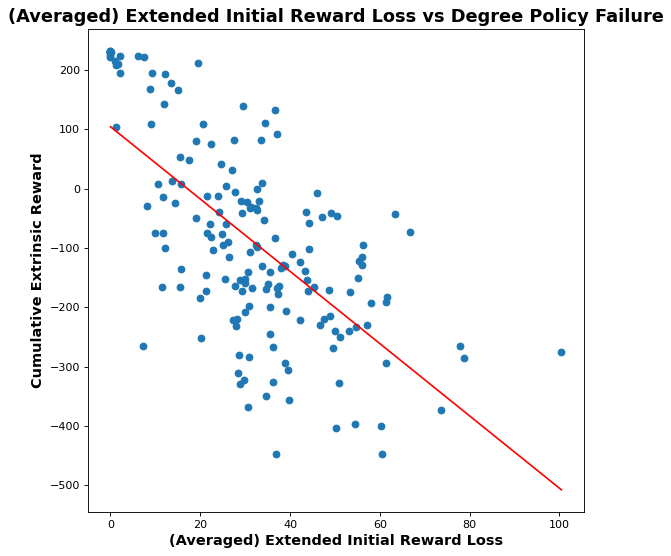

In [24]:
average_extended_initial_reward_loss = np.nanmean(extended_initial_reward_loss, axis=2)
average_degree_failure = np.nanmean(degree_failure, axis=2)

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.scatter(average_extended_initial_reward_loss.flatten(), average_degree_failure.flatten())
ax.set_xlabel("(Averaged) Extended Initial Reward Loss", fontweight="bold", size=13)
ax.set_ylabel("Cumulative Extrinsic Reward", fontweight="bold", size=13)
ax.set_title("(Averaged) Extended Initial Reward Loss vs Degree Policy Failure", fontweight="bold", size=16)

ax.plot(np.unique(average_extended_initial_reward_loss.flatten()), np.poly1d(
            np.polyfit(average_extended_initial_reward_loss.flatten(), 
            average_degree_failure.flatten(), 1))(np.unique(average_extended_initial_reward_loss.flatten())),
        color="red")
       
plt.show()
# plt.savefig('averaged_extended_initial_reward_loss_scatterplot.png')

### Ensure reward loss spikes happen at changepoint
Majority of max reward spikes happen within 25 "steps"

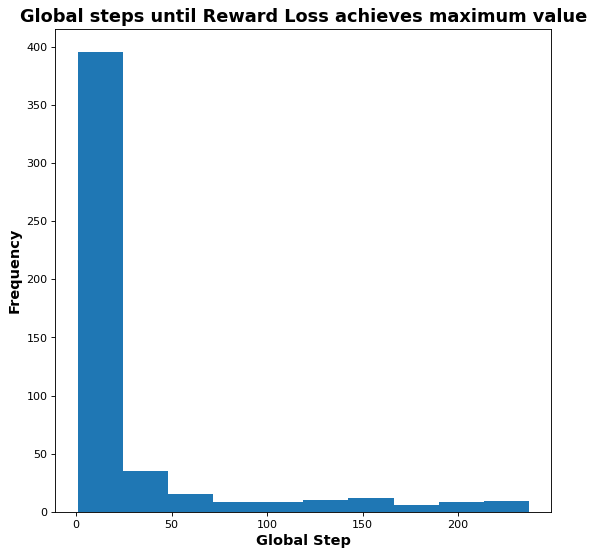

In [21]:
max_reward_loss_indices = np.nanargmax(da[:,:,:,metric_indices["RewardPredictor/loss"],mid_time_step:], axis=3).flatten()

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

ax.hist(max_reward_loss_indices)
ax.set_xlabel("Global Step", fontweight="bold", size=13)
ax.set_ylabel("Frequency", fontweight="bold", size=13)
ax.set_title("Global steps until Reward Loss achieves maximum value", fontweight="bold", size=16)

plt.show()
# plt.savefig('steps_until_reward_loss_maximum_histogram.png')

### Normalise data

In [25]:
initial_state_model_loss = np.array(da[:,:,:,metric_indices["icm/policy_loss"],mid_time_step+1]).flatten()
initial_reward_model_loss = np.array(da[:,:,:,metric_indices["RewardPredictor/loss"],mid_time_step+1]).flatten()

Text(0.5, 1.0, 'Scaled combined model loss vs Max Reward Loss')

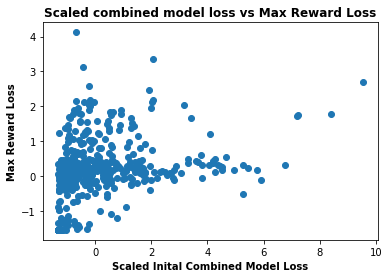

In [26]:
scaled_initial_reward_model_loss = (initial_reward_model_loss - np.mean(initial_reward_model_loss)) \
                                    / np.std(initial_reward_model_loss)
scaled_initial_state_model_loss = (initial_state_model_loss - np.mean(initial_state_model_loss)) \
                                    / np.std(initial_state_model_loss)
scaled_initial_combined_model_loss = scaled_initial_reward_model_loss + scaled_initial_state_model_loss
scaled_max_reward_loss = (max_reward_loss.flatten() - np.mean(max_reward_loss.flatten())) \
                            / np.std(max_reward_loss.flatten())

plt.scatter(scaled_initial_combined_model_loss, scaled_max_reward_loss)
plt.xlabel("Scaled Inital Combined Model Loss", fontweight="bold")
plt.ylabel("Max Reward Loss", fontweight="bold")
plt.title("Scaled combined model loss vs Max Reward Loss", fontweight="bold")

### Min/Max scaling

No benefit to Min/Max scaling or log transform

Text(0.5, 1.0, 'Scaled combined model loss vs Max Reward Loss')

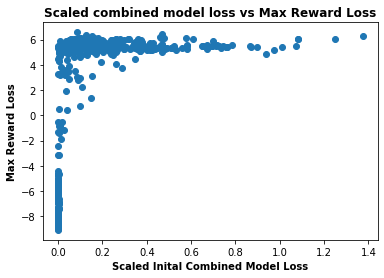

In [27]:
scaled_initial_reward_model_loss = (initial_reward_model_loss - initial_reward_model_loss.min()) \
                                        / (initial_reward_model_loss.max() - initial_reward_model_loss.min())
scaled_initial_state_model_loss = (initial_state_model_loss - initial_state_model_loss.min()) \
                                        / (initial_state_model_loss.max() - initial_state_model_loss.min())
scaled_initial_combined_model_loss = scaled_initial_reward_model_loss + scaled_initial_state_model_loss

plt.scatter(scaled_initial_combined_model_loss, np.log(max_reward_loss))
plt.xlabel("Scaled Inital Combined Model Loss", fontweight="bold")
plt.ylabel("Max Reward Loss", fontweight="bold")
plt.title("Scaled combined model loss vs Max Reward Loss", fontweight="bold")

## Time until convergence

In [28]:
da.shape

(13, 13, 3, 11, 489)

In [100]:
reward_after_domain_shift = da[:,:,:,metric_indices["RewardPredictor+ICM/reward_extrinsic"], mid_time_step+1:]
average_reward_after_domain_shift = np.nanmean(reward_after_domain_shift, axis=2)
reward = da[:,:,:,metric_indices["RewardPredictor+ICM/reward_extrinsic"],:]
average_reward = np.nanmean(reward, axis=2)

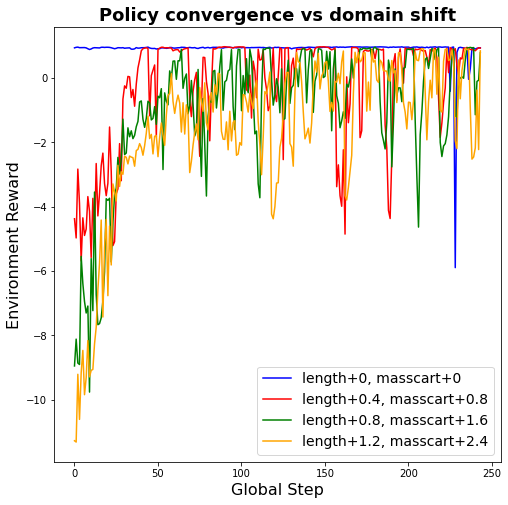

In [99]:
plt.figure(figsize=(8,8))
plt.plot(range(244), average_reward_after_domain_shift[0,0], color="blue", label="length+0, masscart+0")
plt.plot(range(244), average_reward_after_domain_shift[4,4], color="red", label="length+0.4, masscart+0.8")
plt.plot(range(244), average_reward_after_domain_shift[8,8], color="green", label="length+0.8, masscart+1.6")
plt.plot(range(244), average_reward_after_domain_shift[12,12], color="orange", label="length+1.2, masscart+2.4")

plt.xlabel("Global Step", fontsize=16)
plt.ylabel("Environment Reward", fontsize=16)
plt.title("Policy convergence vs domain shift", fontsize=18, fontweight="bold")
plt.legend(fontsize=14)
# plt.savefig("policy_convergence_vs_domain_shift.png")

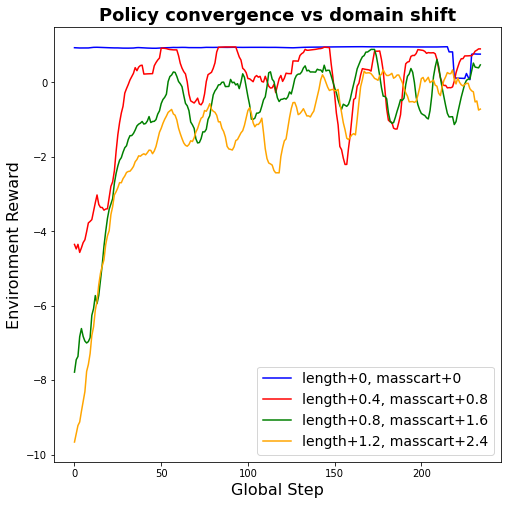

In [98]:
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
smoothed_average_reward_after_domain_shift_1 = np.convolve(average_reward_after_domain_shift[0,0], kernel, mode='valid')
smoothed_average_reward_after_domain_shift_2 = np.convolve(average_reward_after_domain_shift[4,4], kernel, mode='valid')
smoothed_average_reward_after_domain_shift_3 = np.convolve(average_reward_after_domain_shift[8,8], kernel, mode='valid')
smoothed_average_reward_after_domain_shift_4 = np.convolve(average_reward_after_domain_shift[12,12], kernel, mode='valid')

plt.figure(figsize=(8,8))
plt.plot(range(235), smoothed_average_reward_after_domain_shift_1, color="blue", label="length+0, masscart+0")
plt.plot(range(235), smoothed_average_reward_after_domain_shift_2, color="red", label="length+0.4, masscart+0.8")
plt.plot(range(235), smoothed_average_reward_after_domain_shift_3, color="green", label="length+0.8, masscart+1.6")
plt.plot(range(235), smoothed_average_reward_after_domain_shift_4, color="orange", label="length+1.2, masscart+2.4")

plt.xlabel("Global Step", fontsize=16)
plt.ylabel("Environment Reward", fontsize=16)
plt.title("Policy convergence vs domain shift", fontsize=18, fontweight="bold")
plt.legend(fontsize=14)
# plt.savefig("policy_convergence_vs_domain_shift_smoothed.png")

## Largest reward loss spike always occurs at beginning

In [132]:
reward_losses = da[:,:,:,metric_indices["RewardPredictor/loss"],:]
average_reward_losses = np.nanmean(reward_losses, axis=2)

<ipython-input-132-15595c1eccf4>:2: RuntimeWarning: Mean of empty slice
  average_reward_losses = np.nanmean(reward_losses, axis=2)


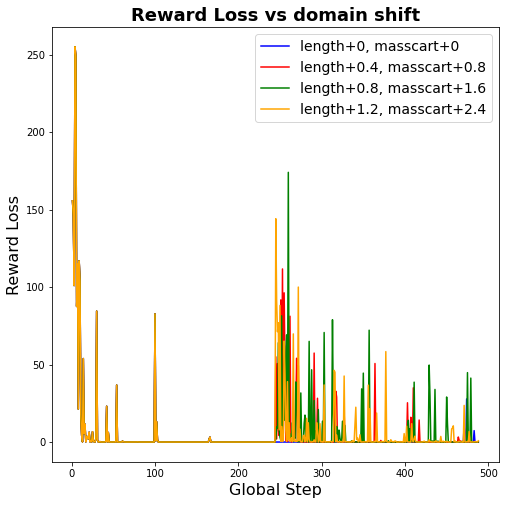

In [118]:
average_reward_losses_1 = average_reward_losses[0,0,:]
average_reward_losses_2 = average_reward_losses[4,4,:]
average_reward_losses_3 = average_reward_losses[8,8,:]
average_reward_losses_4 = average_reward_losses[12,12,:]


plt.figure(figsize=(8,8))
plt.plot(range(489), average_reward_losses_1, color="blue", label="length+0, masscart+0")
plt.plot(range(489), average_reward_losses_2, color="red", label="length+0.4, masscart+0.8")
plt.plot(range(489), average_reward_losses_3, color="green", label="length+0.8, masscart+1.6")
plt.plot(range(489), average_reward_losses_4, color="orange", label="length+1.2, masscart+2.4")

plt.xlabel("Global Step", fontsize=16)
plt.ylabel("Reward Loss", fontsize=16)
plt.title("Reward Loss vs domain shift", fontsize=18, fontweight="bold")
plt.legend(fontsize=14)
# plt.savefig("reward_loss_across_entire_training.png")

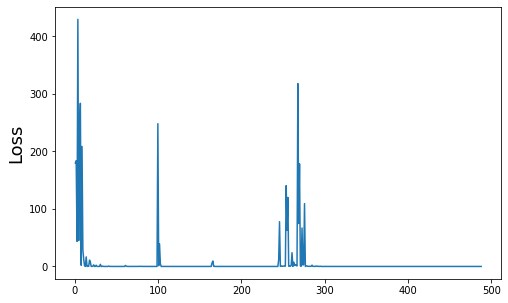

In [134]:
plt.figure(figsize=(8,5))
plt.plot(range(489), reward_losses[6,6,1])
plt.ylabel("Loss", fontsize=18)
# plt.savefig("cartpole_reward_loss.png")

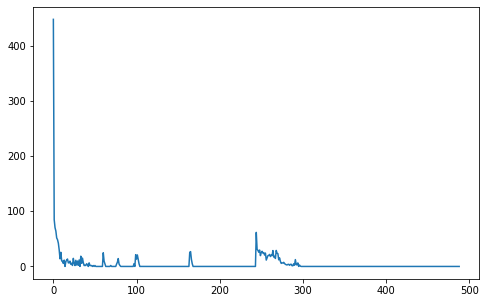

In [138]:
prediction_reward_intrinsic = da[:,:,:,metric_indices["RewardPredictor/prediction_reward_intrinsic"],:]
average_prediction_reward_intrinsic = np.nanmean(prediction_reward_intrinsic, axis=2)

plt.figure(figsize=(8,5))
plt.plot(range(489), prediction_reward_intrinsic[6,6,1])
